In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

# Person of Interest Classifier - Enron Dataset

*by Johannes Bock, January 25, 2017*

In 2000, Enron was one of the largest companies in the United States. By 2002, it had collapsed into bankruptcy due to widespread corporate fraud. In the resulting Federal investigation, a significant amount of typically confidential information entered into the public record, including tens of thousands of emails and detailed financial data on top executives. In this project, I will build a person of interest identifier based on financial data, email meta-data and 250.000 emails made public as a result of the Enron scandal. <br><br>As you will see at the end of the projet, I could build a classifier, which in **87 %** (precision-score) of the cases is correct, when predicting an Enron employee to be a person of interest in the Enron fraud case. 

## Project goal

In the following project I will follow a common machine learning process in order to build a classification model to identify Enron employees who may have committed fraud based on imperfect data from the Enron scandal. I will train a machine learning algorithm to recognize the patterns that are typical for the actions of fraudulent employees in the Enron case. I will go through the following steps (not necessarily in that strict order, but rather iteratively):
1. Data pre-processing
    * Data exploration
    * Outlier investigation
2. Feature Engineering & Feature Selection
    * Feature creation
    * Feature scaling
    * Feature transformation (i.e. Dimensionality reduction)
    * Feature selection/ Feature importance
3. Model selection
4. Model tuning
5. Model evaluation & cross-validation

##  Dataset

First, the dataset is being loaded into memory. It is of the following shape:

In [1]:
import pickle
import sys
import pandas as pd
import numpy as np


# Set the random_state for the following analysis for reproducibility
random_state=42

#Load the the financial and email data into a pandas dataframe
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)
    
df = pd.DataFrame.from_dict(data_dict).transpose()
df = df.replace({'NaN': None}, regex=True)
df = df.drop("TOTAL")

print df.shape
df.head()

(145, 21)


,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
ALLEN PHILLIP K,4175000.0,2869717.0,-3081055.0,NaN,phillip.allen@enron.com,1729541.0,13868.0,2195.0,47.0,65.0,...,304805.0,152.0,False,126027.0,-126027.0,201955.0,1407.0,2902.0,4484442.0,1729541.0
BADUM JAMES P,NaN,178980.0,NaN,NaN,None,257817.0,3486.0,NaN,NaN,NaN,...,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,182466.0,257817.0
BANNANTINE JAMES M,NaN,NaN,-5104.0,NaN,james.bannantine@enron.com,4046157.0,56301.0,29.0,39.0,0.0,...,NaN,864523.0,False,1757552.0,-560222.0,477.0,465.0,566.0,916197.0,5243487.0
BAXTER JOHN C,1200000.0,1295738.0,-1386055.0,NaN,None,6680544.0,11200.0,NaN,NaN,NaN,...,1586055.0,2660303.0,False,3942714.0,NaN,267102.0,NaN,NaN,5634343.0,10623258.0
BAY FRANKLIN R,400000.0,260455.0,-201641.0,NaN,frank.bay@enron.com,NaN,129142.0,NaN,NaN,NaN,...,NaN,69.0,False,145796.0,-82782.0,239671.0,NaN,NaN,827696.0,63014.0


There are records for 145 Enron employees, which is a fairly small sample from a machine learning perspective. There are 21 features describing each employee including financial information and email meta data. 

**Missing data**

In [2]:
df.count()

bonus                         81
deferral_payments             38
deferred_income               48
director_fees                 16
email_address                111
exercised_stock_options      101
expenses                      94
from_messages                 86
from_poi_to_this_person       86
from_this_person_to_poi       86
loan_advances                  3
long_term_incentive           65
other                         92
poi                          145
restricted_stock             109
restricted_stock_deferred     17
salary                        94
shared_receipt_with_poi       86
to_messages                   86
total_payments               124
total_stock_value            125
dtype: int64

In [3]:
df = df.drop(["deferral_payments","deferred_income","director_fees","loan_advances","long_term_incentive",
        "restricted_stock_deferred"],axis=1)
df.shape

(145, 15)

Moreover, there is quite a lot of missing data, which, based on the features I select, will further reduce the sample size. Therefore, I removed 6 features with more than 50% of missing data straight away. The target variable **Person of Interest (poi)** contains a boolean value, which takes *True* for all individuals who were indicted, reached a settlement or plea deal with the government, or testified in exchange for prosecution immunity.

In [4]:
df["poi"].value_counts()

False    127
True      18
Name: poi, dtype: int64

There are only 18 persons of interest in the dataset, which shows a large imbalance in the distribution of the target classes. Therefore, I will use *stratified sampling* for training and cross-validation of my model.

## Financial data

In [5]:
fin_features = ['salary', 'total_payments', 'bonus', "restricted_stock",'total_stock_value', 'expenses', 
                'exercised_stock_options', 'other',"poi"]
mail_features = ['to_messages', 'email_address', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 
                'shared_receipt_with_poi',"poi"]
corrmat = df[fin_features].corr()

corrmat

,salary,total_payments,bonus,restricted_stock,total_stock_value,expenses,exercised_stock_options,other,poi
salary,1.000000,0.579260,0.523190,0.550824,0.614736,0.145364,0.607324,0.606903,0.264976
total_payments,0.579260,1.000000,0.569054,0.595728,0.668166,0.109798,0.591690,0.825444,0.230692
bonus,0.523190,0.569054,1.000000,0.376992,0.509441,0.033799,0.506998,0.376371,0.302384
restricted_stock,0.550824,0.595728,0.376992,1.000000,0.855250,0.042896,0.690935,0.644357,0.224814
total_stock_value,0.614736,0.668166,0.509441,0.855250,1.000000,0.034707,0.963560,0.627171,0.366462
expenses,0.145364,0.109798,0.033799,0.042896,0.034707,1.000000,0.019412,0.062874,0.060292
exercised_stock_options,0.607324,0.591690,0.506998,0.690935,0.963560,0.019412,1.000000,0.536248,0.503551
other,0.606903,0.825444,0.376371,0.644357,0.627171,0.062874,0.536248,1.000000,0.120510
poi,0.264976,0.230692,0.302384,0.224814,0.366462,0.060292,0.503551,0.120510,1.000000


In order to get a sense of the financial data and its bivariate relationships I looked at correlations. From the correlation matrix above, it becomes fairly clear that some of the financial features are highly correlated (> 0.9). Therefore, I decided to perform feature selection for the financial features, since adding highly correlated features to my model would most likely not improve model performance and only increase model complexity.

For my feature selection scheme I used sklearn's SelectKBest method, where the chi-square function assigns scores to the features based on the likelihood that they are of significance when predicting the target class. Moreover, I used a GradientBoostedTree classifier and hyperparameter grid search to find the optimal and 10-fold cross-validated k-value that maximizes my performance metrics (f1-score).

In [6]:
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV,StratifiedShuffleSplit
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
from sklearn.metrics import make_scorer,f1_score
import warnings
warnings.filterwarnings('ignore')

le = LabelEncoder()

fin_df = df[fin_features].dropna()
label = le.fit_transform(fin_df.pop("poi"))

selection = SelectKBest(k=1)
scaling = MinMaxScaler()

# Build estimator from scaled features and Univariate selection:
combined_features = FeatureUnion([("scaler", scaling), ("univ_select", selection)])

# Use combined features to transform dataset:
X_features = combined_features.fit(fin_df, label).transform(fin_df)

gbc = GradientBoostingClassifier(random_state=random_state)

# Do grid search over k:
pipeline = Pipeline([("features", combined_features), ("gbc", gbc)])

param_grid = dict(features__univ_select__k=range(1,9))

# Set custom scoring function
f1_score = make_scorer(f1_score, pos_label=1, average='binary')

grid_search = GridSearchCV(pipeline, param_grid=param_grid,cv=StratifiedShuffleSplit(10,random_state=random_state),scoring = f1_score,verbose=1)
grid_search.fit(fin_df, label)
print grid_search.best_score_ 
print grid_search.best_params_

Fitting 10 folds for each of 8 candidates, totalling 80 fits
0.1
{'features__univ_select__k': 1}


[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    5.2s finished


In [7]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

fin_df = df[fin_features].dropna()
label = fin_df.pop("poi")

sel = SelectKBest(chi2, k=1)
fin_df_new = sel.fit_transform(fin_df, label)

selected_f = sel.get_support()
sel_fin_features = list(fin_df.columns[selected_f])

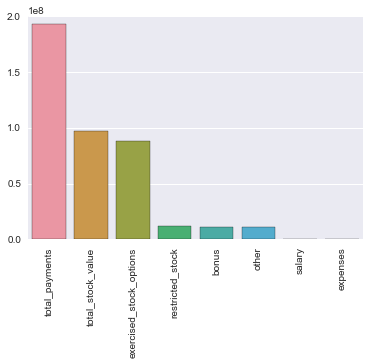

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
scores = sel.scores_
ax = sns.barplot(fin_df.columns,scores,order=fin_df.columns[np.argsort(scores)[::-1]])
ax.set_xticklabels(fin_df.columns[np.argsort(scores)[::-1]],rotation='vertical')

The cross-validation procedure described above suggests that k=1 is the optimal parameter choice. Moreover, the bar chart above shows the relative feature importance derived from the chi-squared support scores for each individual feature and clearly, the variable **total_payments** scores the strongest support. Hence, this will be the only financial feature, that I will use for training the model.

### Outlier investigation - Financial features

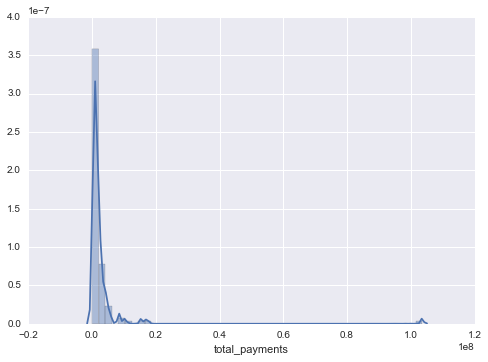

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set()
sel_fin_features.append("poi")
data = df[sel_fin_features].dropna()

sns.distplot(data["total_payments"])

In [10]:
data.sort_values("total_payments",ascending=False).head()

,total_payments,poi
LAY KENNETH L,103559793.0,True
FREVERT MARK A,17252530.0,False
BHATNAGAR SANJAY,15456290.0,False
LAVORATO JOHN J,10425757.0,False
SKILLING JEFFREY K,8682716.0,True


From the histogram above, it is apparent that there may be some issues with outliers in the financial data. In order to improve the ability of the algorithm to generalize from the data, I decided to remove LAY KENNETH L from the training data since he clearly is an exceptional case and might obscure the classifier.

Number of cleaned data points:  1
Number of POI remaining:  17


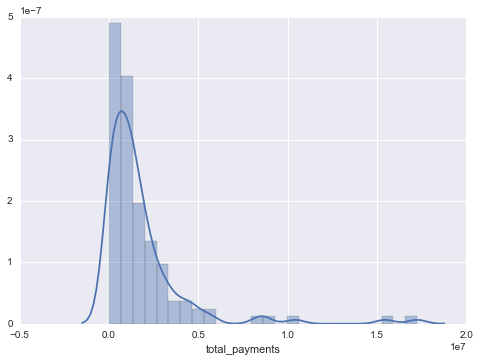

In [11]:
cleaned_fin_df = data.drop("LAY KENNETH L")

sns.distplot(cleaned_fin_df["total_payments"])

print "Number of cleaned data points: ", data.shape[0]-cleaned_fin_df.shape[0]
print "Number of POI remaining: ", cleaned_fin_df["poi"].value_counts()[1]

In total **1** extreme observations was eliminated and **17** persons of interest remain in the dataset.

## Email data

Moving on, I will now investigate the email metadata available.

In [12]:
mail_df = df[mail_features]
print mail_df.shape
mail_df = mail_df.drop("email_address",axis=1)
mail_df.head()

(145, 7)


,to_messages,from_poi_to_this_person,from_messages,from_this_person_to_poi,shared_receipt_with_poi,poi
ALLEN PHILLIP K,2902.0,47.0,2195.0,65.0,1407.0,False
BADUM JAMES P,NaN,NaN,NaN,NaN,NaN,False
BANNANTINE JAMES M,566.0,39.0,29.0,0.0,465.0,False
BAXTER JOHN C,NaN,NaN,NaN,NaN,NaN,False
BAY FRANKLIN R,NaN,NaN,NaN,NaN,NaN,False


There are 7 features related to mailing data, however, the feature **email_address** is likely to be a leakage variable and also contains no relevant information, which is why it is discarded straight away.

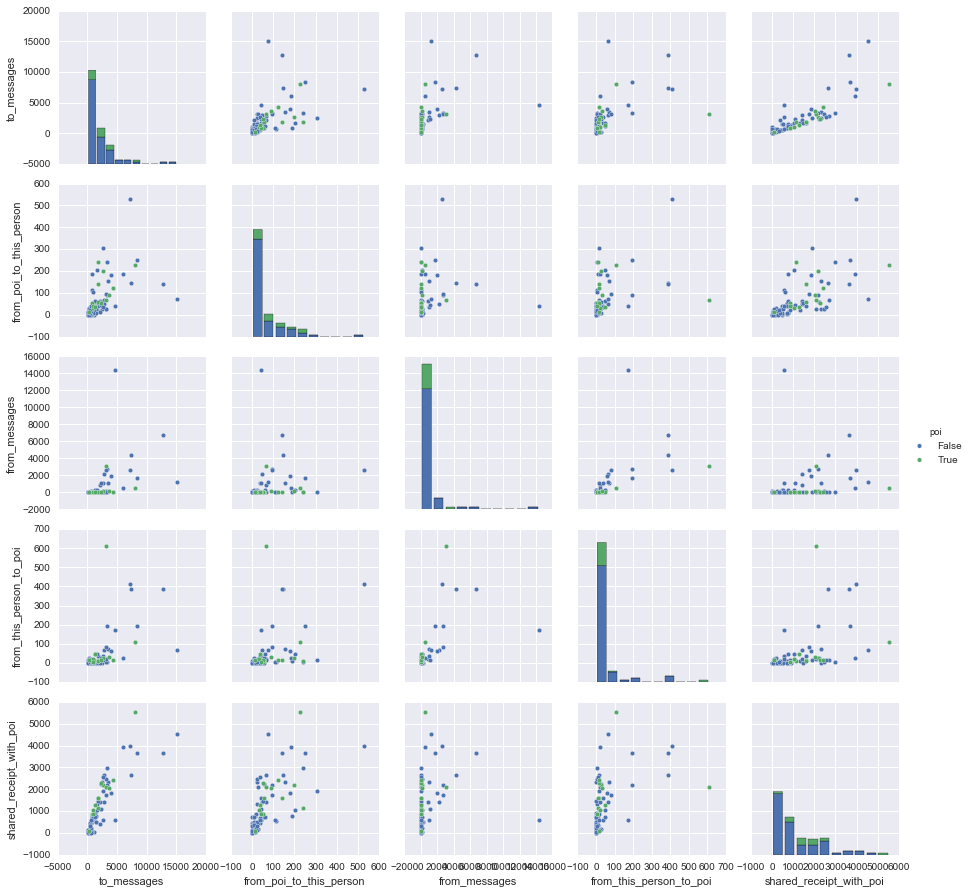

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.pairplot(mail_df.dropna(), hue="poi",vars = ["to_messages","from_poi_to_this_person","from_messages","from_this_person_to_poi",
                                       "shared_receipt_with_poi"])

From the scatter matrix above with all mail features in the data set, I conclude that there might be outliers for **from_messages** and **from_poi_to_this_person**. Moreover, there are some linear relationships among the features. To make more sense of these relationships I calculated new features using **from_messages** and **to_messages** as points of reference.

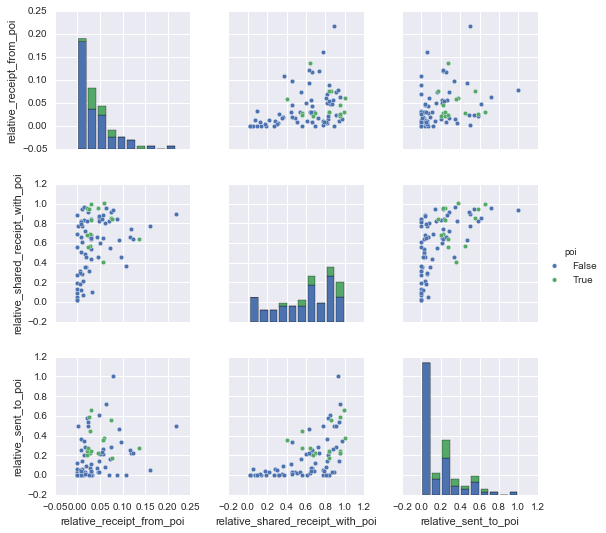

In [14]:
mail_df_new = mail_df

# Relative features based on to_messages
mail_df_new["relative_receipt_from_poi"] = mail_df_new["from_poi_to_this_person"]/mail_df_new["to_messages"]*1.0
mail_df_new["relative_shared_receipt_with_poi"] = mail_df_new["shared_receipt_with_poi"]/mail_df_new["to_messages"]*1.0

# Relative features based on from_messages
mail_df_new["relative_sent_to_poi"] =mail_df_new["from_this_person_to_poi"]/mail_df_new["from_messages"]*1.0

mail_df_new = mail_df_new[["relative_receipt_from_poi","relative_shared_receipt_with_poi","relative_sent_to_poi","poi"]]

sns.pairplot(mail_df_new.dropna(), hue="poi",vars = ["relative_receipt_from_poi","relative_shared_receipt_with_poi",
                                                     "relative_sent_to_poi"])

I have created three new features, which are according to the scatter plots above much better capable of separating the target classes:
1. **relative_receipt_from_poi** - fraction of total mails received from a POI
2. **relative_shared_receipt_with_poi** - fraction of total mails received, where a POI also received the same email
3. **relative_sent_to_poi** - fraction of total mails sent to a POI 


In [15]:
cleaned_mail_data = mail_df_new.dropna().drop("poi",axis=1)
no_text_data = cleaned_fin_df.merge(cleaned_mail_data,left_index=True,right_index=True,copy=False)
print cleaned_fin_df.shape
print no_text_data.shape
no_text_data["poi"].value_counts()

(123, 2)
(74, 5)


False    61
True     13
Name: poi, dtype: int64

When joining the financial and email metadata a total of 74 observations/ samples remain in the dataset, including a total of 13 persons of interest (POI's).

### Feature extraction - Mail content

So far, I have accumulated a feature set which consists of five variables containing financial information and email metadata for each individual person in the dataset. However, I assume that the mail content itself contains most likely fairly distinctive features for POI's. By applying common sense, we can expect that Enron employees involved in criminal activities were concerned and hence, wrote about different topics compared to lawful employees.


In [16]:
%%time

import os
import sys
from parse_out_email_text import getMails

if 0==1:
    cwd = os.getcwd()
    path = cwd + "\emails_by_address\\"
    files = os.listdir(path)

    mails_content_data = []

    for item in files:
        records = getMails(item,path)
        if records != None:
            mails_content_data.extend(records)

    mails_df = pd.DataFrame.from_dict(mails_content_data)

    # Lets save the 246.000 mails
    mails_df.to_pickle(cwd+"email_content.pkl")

    print mails_df.shape


Wall time: 1e+03 µs


In order to get the mail content for the 111 Enron employees (actually the mail data for 25 employees is not available) I wrote a function, which parses through all the email data files and extracts the content of the mails into a pandas dataframe. (The email content data was downloaded from: [Enron Email Dataset](https://www.cs.cmu.edu/~./enron/))

In [17]:
mails_df = pd.read_pickle("email_content.pkl")
print len(mails_df)
mails_df.head()

245893


,email_address,mail_content,mail_type
0,a..martin@enron.com,eric bass 62502PST\n\nTry to go to this if yo...,from
1,a..martin@enron.com,eric bass 62502PST\n\nAny thoughts\n\nTom\n\n...,from
2,a..martin@enron.com,SBRAWNE NonPrivilegedpst\n\nIf you dont know ...,from
3,a..martin@enron.com,dfarmer NonPrivilegedpst\n\nThought you guys ...,from
4,a..martin@enron.com,darren farmer 62602pst\n\n\n\n Original Messa...,from


In [18]:
mails_df.groupby('email_address')["email_address"].nunique(dropna=True).count()

86

The mails_data includes 246.000 mails for 86 Enron employees in our dataset. In order to use this text data for training a predictive model, some text pre-processing is required.

#### Pre-processing the mails data

For processing the text data I will use the [SpaCy](www.spacy.io) and [Gensim](https://radimrehurek.com/gensim/) libraries, which implement convenient algorithms for pre-processing and modelling text-based data.

In [19]:
# Loading the packages and the data
import spacy
nlp = spacy.load('en')
mails_df = pd.read_pickle("email_content.pkl")

In [20]:
import re
import random

line = 232027
print line
print
print "Old:"
print mails_df.iloc[line,1]
print
print "New:"

try:
    fwd_pattern = re.compile (r"^(.*?)\n\n(.*?)(Original Message|Forwarded)(.*)",re.DOTALL)
    matched_txt = fwd_pattern.search(mails_df.iloc[line,1])
    print matched_txt.group(2)
except:
    normal_pattern = re.compile (r"^(.*?)\n\n(.*)",re.DOTALL)
    matched_txt = normal_pattern.search(mails_df.iloc[line,1])
    print matched_txt.group(2)
    

232027

Old:
 swhite NonPrivilegedpst


The preliminary should be out by the end of the day on the 2nd of January 
not the 1st as noted below

Sorry for the confusion

Regards


 Original Message
From 09Wilson Shona 20
Sent09Friday December 28 2001 914 AM
To09Abel Chris Andrews Naveen Apollo Beth Beck Sally Belden Tim
 Bowen Jr Raymond Bradford William S Brooks Loretta Buy Rick Cast
leman Kent Causey Richard Cockrell Rainier Colwell Wes Curry Wanda
 Day Misti Delainey David W Dietrich Janet Fallon Jim Frevert Ma
rk Gold Joe Gossett Jeffrey C Haedicke Mark E Hagelmann Bjorn Ha
ll D Todd Hanson Kristen J Hardy Trey Hayden Frank Helton Susan
 Hickerson Gary Hillis Kimberly Hodges Georgeanne Kaminski Vince J 
Kass Michael Kathol Sherri Killen Faith Kitchen Louise Lavorato Jo
hn Lay Kenneth McKinney Hal McMahon Jeffrey Mills Scott Moscoso M
ichael E Murphy Ted New James Piper Greg Port David Presto Kevin
 M Schmidt Darin Schoppe Tammie Shepperd Tammy R Talley Darin Ue
ckert Allen W Valdez V

As you can see above the original mails data (referred to as Old) is still some kind of messy. Therefore, I will try to clean the data a little bit, which you can see at the bottom (referred to as New):
1. In all mails the first line is a file description, but not part of the mail body. Therefore I will remove that line.
2. A lot of emails have "Original Messages" or "Forwarded" messages attached. In order to prevent an email to show up multiple times in the analysis and therefore, being overemphasized, I will remove these attachements.

In [21]:
%%time

# Be careful, it will take some time to go through all 245.000 mails

if 0==1:
    for i, row in mails_df.iterrows():
        content = row["mail_content"]
        try:
            matched_txt = fwd_pattern.search(content)
            row["mail_content"] = matched_txt.group(2)
        except:
            matched_txt = normal_pattern.search(content)
            row["mail_content"] = matched_txt.group(2)

    # Lets save the cleaned mails
    mails_df.to_pickle(cwd+"email_content_clean.pkl")

    print mails_df.iloc[line,1]
mails_df = pd.read_pickle("email_content_clean.pkl")    

Wall time: 1.26 s


In [22]:
print mails_df.iloc[line,1]


The preliminary should be out by the end of the day on the 2nd of January 
not the 1st as noted below

Sorry for the confusion

Regards


 


After pre-processing the mails content, we get the clean and raw email-messages like the one shown above.

In [23]:
%%time
if 0 ==1:
    for i, row in mails_df.iterrows():
        row["mail_content"] = unicode(row["mail_content"].replace('\n\n', '\n'),"utf-8")
    mails_df.to_pickle("email_content_cleaned_uni.pkl")

Wall time: 0 ns


In [24]:
%%time
mails_df = pd.read_pickle("email_content_cleaned_uni.pkl")

contents = list(mails_df["mail_content"])
parsed_content = nlp(contents[line])

Wall time: 1.46 s


In [25]:
token_text = [token.orth_ for token in parsed_content]
token_pos = [token.pos_ for token in parsed_content]
token_entity_type = [token.ent_type_ for token in parsed_content]
token_lemma = [token.lemma_ for token in parsed_content]
token_stop = [token.is_stop for token in parsed_content]

pd.DataFrame(zip(token_text, token_pos,token_entity_type,token_lemma,token_stop),
             columns=['token_text', 'part_of_speech',"Entity_type","token_lemma","stopword"]).head()

,token_text,part_of_speech,Entity_type,token_lemma,stopword
0,\n,SPACE,,\n,False
1,The,DET,,the,True
2,preliminary,ADJ,,preliminary,False
3,should,VERB,,should,True
4,be,VERB,,be,True


The table above shows, how the mail body is tokenized using SpaCy. Moreover, SpaCy has efficient built-in functions for lemmatization,POS-tagging, Named-Entity-Recognition and stop word recognition. I will use these functions to normalize and further clean the content of the emails.

In [26]:
%%time

# Normalize all emails in the data set
if 0==1:
    from process_text import process_all_mails

    tidy_contents = process_all_mails(mails_df["mail_content"])

Wall time: 0 ns


In [27]:
import cPickle
tidy_contents = cPickle.load(open('normal_contents.p', 'rb'))
tidy_contents[line]

'preliminary end day 2nd january 1st note sorry confusion regard'

After applying the spaCy algorithms, the dataset now only contains the cleaned and lemmatized words as shown in the example above. Note how the email data has changed compared to the original mail content. This data is now being added to our mail content dataset.

In [28]:
#add the cleaned mail content to the mails_df and save it
mails_df=pd.read_pickle("final_mails_data.pkl")
if 0 == 1:
    import numpy as np
    m = np.asarray(tidy_contents)
    mails_df["clean_mail_content"] = m

    mails_df.to_pickle("final_mails_data.pkl")
mails_df.head()

,email_address,mail_content,mail_type,clean_mail_content
0,a..martin@enron.com,Try to go to this if you can\nTom\n,from,try tom
1,a..martin@enron.com,Any thoughts\nTom\n,from,thought tom
2,a..martin@enron.com,If you dont know you should know by now that y...,from,not know know apologize tom
3,a..martin@enron.com,Thought you guys might like to see this\nTom\n,from,thought guy like tom
4,a..martin@enron.com,\n,from,None


In [29]:
# Get name index
warnings.filterwarnings('ignore')

index = df[["email_address"]]
index["names"] = df.index
mails_df = mails_df.merge(index, on="email_address", how='inner')
mails_df.head()

,email_address,mail_content,mail_type,clean_mail_content,names
0,a..martin@enron.com,Try to go to this if you can\nTom\n,from,try tom,MARTIN AMANDA K
1,a..martin@enron.com,Any thoughts\nTom\n,from,thought tom,MARTIN AMANDA K
2,a..martin@enron.com,If you dont know you should know by now that y...,from,not know know apologize tom,MARTIN AMANDA K
3,a..martin@enron.com,Thought you guys might like to see this\nTom\n,from,thought guy like tom,MARTIN AMANDA K
4,a..martin@enron.com,\n,from,None,MARTIN AMANDA K


In order to join the financial data, the email metadata and the mail text data, I need to prepare both dataset for merging. The names (as shown above in the last column) serve as indices and hence, will help to accomplish that.

In [30]:
mails_df=mails_df[["names","clean_mail_content"]]
mails_df=mails_df.dropna()
mails_df["names"].nunique()

86

Next, I will join all mails for each unique name index to get one document with all mails per POI (in total 86).

In [31]:
grouped = mails_df.groupby("names")
grouped = grouped["clean_mail_content"].apply(lambda x: "%s" % ' '.join(x))

In [32]:
no_text_data.shape

(74, 5)

In [33]:
full_data = no_text_data.join(grouped,how="inner")
full_data.to_pickle("full_dataset.pkl")
full_data.shape

(74, 6)

Finally, I have merged the financial data, email metadata and text data into one dataset, which will server as the basis for all analysis from now on. Note that there are now only 74 observations left, since 12 persons in the financial dataset did not have any record in the email text data. Therefore, these had to be dropped.

#### Simple TF-IDF representation of mail data for each POI

In order to use the mails content for training an algorithm, the text data needs to be transformed into some kind of numerical representation. The following is one option to achieve this.

In [34]:
full_data = pd.read_pickle("full_dataset.pkl")

# Randomize dataset as it is currently sorted alphabetically
np.random.seed(random_state)
full_data = full_data.reindex(np.random.permutation(full_data.index))

In [35]:
%%time

from sklearn.feature_extraction.text import TfidfVectorizer
grouped = full_data["clean_mail_content"]
vectorizer = TfidfVectorizer(stop_words="english",ngram_range=(1, 1),
                            max_df=0.7,min_df=0.1)
X = vectorizer.fit_transform(grouped)

Wall time: 33.1 s


In [36]:
X.shape

(74, 23664)

In [37]:
vocab = vectorizer.vocabulary_

The code above extracted a [TF-IDF Matrix](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) (i.e. a term frequency matrix) based on the text data, which can now be used for training a machine learning algorithm (Hyperparameters for the TF-IDF vectorizer are already tuned, please see further below how I tuned them).

#### LDA Topic Distribution of mail content for each POI

Since POI's might talk about specific topics in their emails, it might be useful to create "mail-topic features", which can be included to train the algorithm. This is possible by applying [Gensim's LDA](https://radimrehurek.com/gensim/models/ldamulticore.html) model to the text data and extract the topic distributions for each person in the dataset.

In [38]:
# tokenize the normalized documents
def tokenize(docs):
    texts = []
    for doc in docs:
        tokens = doc.split()
        texts.append(tokens)
    return texts
texts = tokenize(grouped)

In [39]:
from gensim.corpora import Dictionary, MmCorpus
from gensim.matutils import MmReader
warnings.filterwarnings('ignore')

# First build Dictionary from text data
dictionary = Dictionary(texts)

# filter tokens that are very rare or too common from
# the dictionary (filter_extremes) and reassign integer ids (compactify)
dictionary.filter_extremes()
dictionary.compactify()

#Save the dictionary to disk
dictionary.save("mail_dict.dict")

len(dictionary)

33377

First, the text-data is transformed into a Gensim dictionary containing 33,377 words.

In [40]:
%%time

# create Bag-of-Words representation of the text data
def bow_generator(docs):
    """
    generator function to read mail docs
    and yield a bag-of-words representation
    """
    for doc in docs:
        yield dictionary.doc2bow(doc)

# generate bag-of-words representations for
# all mails and save them as a matrix
MmCorpus.serialize("Mail_corpus.mm",
                   bow_generator(texts))
    
# load the finished bag-of-words corpus from disk
bow_corpus = MmCorpus("Mail_corpus.mm")

Wall time: 25.1 s


In [41]:
print MmReader("Mail_corpus.mm")

MmCorpus(74 documents, 33377 features, 428657 non-zero entries)


From the dictionary, I created a bag of words representation of the text-data. This gives the corpus based on which the topic model is being trained.

In [42]:
%%time

from gensim.models.ldamulticore import LdaMulticore
import warnings

with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    lda = LdaMulticore(bow_corpus,
                       num_topics=10,
                       id2word=dictionary,
                       workers=3)

lda.save("lda_model_all")

Wall time: 26.1 s


In [43]:
def explore_topic(topic_number, topn=5):
    """
    accept a user-supplied topic number and
    print out a formatted list of the top terms
    """
        
    print u'{:20} {}'.format(u'term', u'frequency') + u'\n'

    for term, frequency in lda.show_topic(topic_number, topn=5):
        print u'{:20} {:.3f}'.format(term, round(frequency, 3))

In [44]:
explore_topic(topic_number=0)

term                 frequency

said20               0.005
assembly             0.004
avg                  0.003
legislature          0.002
dwr                  0.002


After the topic model has been trained to identify **10 topics** in the data, each topic can be explored separately as shown above for topic no. 1. However, a more convenient way to explore the topics is to use the python library [pyLDAvis](https://github.com/bmabey/pyLDAvis).

In [45]:
import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

LDAvis_prepared = pyLDAvis.gensim.prepare(lda, bow_corpus,
                                          dictionary)
pyLDAvis.display(LDAvis_prepared)

In [46]:
# Get document-topic distribution
doc_top =lda.get_document_topics(bow_corpus)

doc_topic_matrix = []
for POI in doc_top:
    data = {}
    for topic in POI:
        topic_id = topic[0]
        topic_prob = topic[1]
        data[topic_id]=topic_prob
    doc_topic_matrix.append(data)
    
topic_mat = pd.DataFrame.from_dict(doc_topic_matrix)
topic_mat = topic_mat.replace({None: 0})
topic_mat.shape

(74, 10)

Last but not least, I extracted the document-topic distribution found by the LDA model. This dataframe can be now used to train a person of interest classifier based on email-topic features.

## Training data sets

To sum up, I will create three different training sets including different features, which can later be compared.

#### 1. Training data set (No text data)

In [47]:
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
from sklearn.feature_selection import SelectPercentile

# Transforming the target classes
target_classes = full_data["poi"]
le = LabelEncoder()

labels = le.fit_transform(target_classes)
features_no_text = full_data.as_matrix(columns=[u'total_payments',
       u'relative_receipt_from_poi', u'relative_shared_receipt_with_poi',
       u'relative_sent_to_poi'])

# Scale the features
scaler = MinMaxScaler(feature_range=(0, 1))
features_no_text = scaler.fit_transform(features_no_text)

The code above prepares the data set for training by splitting it into features and labels. Moreover, the features are being scaled in order to avoid dominance of some variables simply because of different scales of measurement.

#### 2. Training data set (including TF-IDF representation of text data)

In [48]:
# TF-IDF matrix of all docs
X.shape

(74, 23664)

Since the dataset including the TF-IDF representation of the text data is very high dimensional with 23,600 features, I decided to reduce the dimensionality of it using a similar approach as earlier.

In [49]:
# Performing cross-validated feature-selection

from sklearn.feature_selection import SelectPercentile, f_classif

gbc = GradientBoostingClassifier(random_state=random_state)
selector = SelectPercentile(f_classif, percentile=1)

# Do grid search over percentile:
pipeline = Pipeline([("sel", selector), ("gbc", gbc)])

param_grid = dict(sel__percentile=[0.01,0.1,1,2,3,5,7,10,15,20])

grid_search = GridSearchCV(pipeline, param_grid=param_grid,cv=StratifiedShuffleSplit(20,random_state=random_state),scoring = f1_score,verbose=1)
grid_search.fit(X.toarray(), labels)
print grid_search.best_score_
print grid_search.best_params_

Fitting 20 folds for each of 10 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  1.2min finished


0.6
{'sel__percentile': 20}


In [50]:
# Feature selection
selector = SelectPercentile(f_classif, percentile=20)
X_transformed = selector.fit_transform(X, labels)

text_features_transformed = X_transformed.toarray()
text_features_transformed.shape

(74L, 4732L)

Feature selection is performed using grid search and it turns out that reducing the TF-IDF feature space down to 4732 features (e.g. Top 20 Percentile), the highest cross-validated f1 score is being achieved.

In [51]:
features_no_text.shape

(74L, 4L)

In [52]:
features_tf = np.concatenate((text_features_transformed,features_no_text), axis=1)
features_tf.shape

(74L, 4736L)

Finally, I joined the transformed text data with the financial and email metadata features.

#### 3. Training data set (including topic distribution of text data)

The last dataset variant will include the topic distribution features as well as the financial and email metadata variables.

In [53]:
# Join topic distribution data with non-text data
features_topics = np.concatenate((features_no_text, topic_mat.values), axis=1)
features_topics.shape

(74L, 14L)

### Model validation & evaluation scheme

The goal of this project is to develop a model, which identifies persons of interest in the data set. Therefore, in order to assess the performance of the classifier, I will compute the stratified 10-fold cross validated score for precision, recall and F1-score of class 1 (e.g. POI = True).

### Model selection

Before fine-tuning a modell I want to get an idea, how different parametric and non-parametric models perform on the data. Therefore, I will train a number of non-tuned algorithms on the data to see how they perform with default settings. I will do that for all three datasets including mail content data and excluding mail content data.

In [54]:
# Define a function that takes as input a dict of classifier-objects, a list of training data and the labels for the data
# the function trains the classifier and returns the stratified kfold cross validation score for precision, recall and f1 score of class 1

def test_clf(clf_dict, features,labels,k=50):
    results = []
    
    for clf_name, clf in clf_dict.items():

        cv = StratifiedShuffleSplit(k,random_state=random_state)
        cross_val_precision = []
        cross_val_recall = []
        cross_vall_f1 = []

        for train_indices, test_indices in cv.split(features,labels):
            #make train and testing data
            X_train = [features[ii] for ii in train_indices]
            X_test = [features[ii] for ii in test_indices]
            y_train = [labels[ii] for ii in train_indices]
            y_test = [labels[ii] for ii in test_indices]

            # fit classifier
            clf.fit(X_train,y_train)

            #predict labels
            pred = clf.predict(X_test)

            # get precision score on testing data
            prec_score = precision_score(y_test, pred,pos_label=1, average='binary')
            cross_val_precision.append(prec_score)

            # get recall score on testing data
            rec_score = recall_score(y_test, pred,pos_label=1, average='binary')
            cross_val_recall.append(rec_score)

            # get f1 score on testing data
            f_score = f1_score(y_test, pred,pos_label=1, average='binary')
            cross_vall_f1.append(f_score)
            
        results.append({clf_name: [np.mean(cross_val_precision),np.mean(cross_val_recall),np.mean(cross_vall_f1)]})
        print {clf_name: [np.mean(cross_val_precision),np.mean(cross_val_recall),np.mean(cross_vall_f1)]}
        
    return results

In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
warnings.filterwarnings('ignore')

from sklearn.metrics import precision_score, recall_score,f1_score
from sklearn.model_selection import StratifiedKFold,StratifiedShuffleSplit

#feature_sets = [features_no_text,features_tf,features_topics]

clfs = {'lr': LogisticRegression(random_state=random_state),
        "gnb": GaussianNB(),
        "dt": DecisionTreeClassifier(random_state=random_state),
        'rfc': RandomForestClassifier(random_state=random_state), 
        'svm': SVC(kernel = 'linear', probability = True,random_state=random_state),
        "Ada": AdaBoostClassifier(random_state=random_state),
       "Gradient": GradientBoostingClassifier(random_state=random_state)}
   
results = test_clf(clfs, features_tf, labels)

{'rfc': [0.10333333333333332, 0.14000000000000001, 0.11333333333333333]}
{'svm': [0.0, 0.0, 0.0]}
{'Gradient': [0.63333333333333341, 0.69999999999999996, 0.65333333333333332]}
{'gnb': [0.0, 0.0, 0.0]}
{'lr': [0.0, 0.0, 0.0]}
{'Ada': [0.28666666666666668, 0.34000000000000002, 0.30333333333333329]}
{'dt': [0.56000000000000005, 0.68000000000000005, 0.59333333333333327]}


As it turns out the dataset including the TF-IDF representation of the text data has the most predictive power, followed by the dataset including topic distribution of the text data. This is not surprising, since the LDA topic model could not really find meaninful topics, as the mails data has a lot of spelling errors, each mail is most of the times very short and also contains a lot of noise such as numbers, mail addresses etc. These are all factors, which weaken the performance of the LDA algorithm. <br>
Moreover, the winning algorithm with the highest F1-score is sklearn's GradientBoostingClassifier. Therefore, I will continue with tuning the hyperparameters of this algorithm.

*Please note: I tuned the the hyperparameters of the TF-IDF vectorizer using cross-validation, which is described in the following section*

#### Determining TF-IDF hyperparameters using cross-validation

In order to find the optimal combination between a tunable machine learning algorithm and the optimal hyperparameter settings of the TF-IDF vectorizer (n-grams, max_df and min_df), I defined a function performing grid-search using 10-fold cross-validation.

In [56]:
def vector_cross_val(max_df,min_df,ngram_range,grouped,features_no_text,clfs):
    res = {}
    i = 0
    for ngram in ngram_range:
        for m_val in max_df:
            for l_val in min_df:

                if m_val >= l_val:
                    try:
                        print "Iteration No. ",i
                        i += 1
                        # Transform text to TF-IDF

                        vectorizer = TfidfVectorizer(stop_words="english",ngram_range=ngram,
                                                    max_df=m_val,min_df=l_val)
                        X = vectorizer.fit_transform(grouped)

                        # Select top 20 percent features
                        selector = SelectPercentile(f_classif, percentile=20)
                        X_transformed = selector.fit_transform(X, labels)
                        text_features_transformed = X_transformed.toarray()
                        features_tf = np.concatenate((features_no_text, text_features_transformed), axis=1)
                        
                        results = test_clf(clfs,features_tf, labels,k=10)
                        best_vals = []
                        for algo in results:
                            for trainer in algo:
                                best_vals.append(algo[trainer][2])
                        best = max(best_vals)
                        res[best]=[ngram,m_val,l_val]
                        print "Best F1-Result (ngram={}, max_df={},min_df={}): ".format(ngram,m_val,l_val), best
                    except:
                        continue
                else:
                    continue
    return res

In [57]:
%%time
max_df= [0.6,0.7,0.8,0.9,0.99]
min_df= [0,0.1,0.2,0.3,0.4,0.5]
ngram_range = [(1,1),(1,2)]
grouped = full_data["clean_mail_content"]
clfs = {"dt": DecisionTreeClassifier(random_state=random_state),
        'rfc': RandomForestClassifier(random_state=random_state), 
        "Ada": AdaBoostClassifier(random_state=random_state),
       "Gradient": GradientBoostingClassifier(random_state=random_state)}

if 0==1:
    res = vector_cross_val(max_df,min_df,ngram_range,grouped,features_no_text,clfs)

Wall time: 1e+03 µs


In [58]:
if 0==1:
    print res[max(res)]

After computing the cross-validated f1-scores for different TF-IDF parameters, it turns out that the following parameter settings are optimal:<br>
    1) GradientBoostingClassifier<br>
    2) ngram_range = (1,1)<br>
    3) max_df = 0.7<br>
    4) min_df = 0.1<br>

### Model tuning

The goal of the machine learning process is to find a "best-fitting" model, however there is a tradeoff between a model's ability to minimize bias and variance. Models that have high variance will have low bias, whereas models with high bias will have low variance. The best model finds the right balance between the both and avoids the mistake of over- or under-fitting. To control the model complexity, many machine learning algorithms can be customized via hyperparameter settings that determine how flexible that model is. To find the best hyperparameters based on the f1 score, I will use sklearn's grid search for tuning the GradientBoostingClassifier.

In [59]:
def grid_tune(classifier,features,labels,params,random_state=random_state):
    from sklearn.model_selection import GridSearchCV
    from sklearn.metrics import make_scorer
    from sklearn.metrics import f1_score
    
    f1_score = make_scorer(f1_score, pos_label=1, average='binary')
    clf = GridSearchCV(classifier, params,cv=StratifiedShuffleSplit(10,random_state=random_state),scoring = f1_score,verbose=1)
    clf.fit(features,labels)

    return clf,clf.best_score_,clf.best_params_

In [60]:
%%time 

# GradientBoostedTree

param_grid = {"n_estimators": [5,10,20,30,50,70,100,120,150],
              "learning_rate":[1,0.1,0.05,0.03,0.01,0.005],
              "min_samples_split":[2,4,6,8,9,10,11,12],
             }
gdn = GradientBoostingClassifier(random_state=random_state)
gdn,best_score,best_params = grid_tune(gdn,features_tf,labels,param_grid)
print best_score

Fitting 10 folds for each of 432 candidates, totalling 4320 fits


[Parallel(n_jobs=1)]: Done 4320 out of 4320 | elapsed: 44.4min finished


0.7
Wall time: 44min 27s


In [61]:
best_params

{'learning_rate': 0.01, 'min_samples_split': 2, 'n_estimators': 120}

The grid-search indicated that the following parameters are optimal:<br>
1) learning_rate: 0.01<br>
2) min_samples_split: 2 <br>
3) n_estimators: 120    

### Model evaluation & cross-validation

In order to assess the quality of my classifier, I need to validate its ability to generalize and correctly identify POI's in a new and unseen dataset. Moreover, I need to check if the algorithm overfitted the training data. To accomplish this, I will perform a 1000-fold cross-validation, where the classifier is trained on 90% of the data and tested on 10% of the data 1000 times. Using the StratifiedShuffleSplit function from sklearn, the splitting of the data in training and testing set is randomized. Therefore, this will give an estimate of my model's ability to generalize and its true prediction quality.<br>
The goal of this project is to develop a model, which identifies persons of interest in the dataset. Hence, it will be very costly if our classifier does not correctly identify a true POI (also see: [Recall](https://en.wikipedia.org/wiki/Precision_and_recall)) or wrongly predicts a POI (see: [Precision](https://en.wikipedia.org/wiki/Precision_and_recall)). Therefore, the evaluation metrics for the cross-validation will be Recall and precision, as well as the F1-score of class 1 (POI = True), which is a weighted average of the precision and recall score.

In [62]:
clf = GradientBoostingClassifier(learning_rate = 0.01,min_samples_split = 2,n_estimators = 120,random_state=random_state)

In [63]:
def eval_clf(clf,features,labels,k=1000):
    
    cv = StratifiedShuffleSplit(k,test_size=0.1,random_state=random_state)
    cross_val_precision = []
    cross_val_recall = []
    cross_vall_f1 = []

    for train_indices, test_indices in cv.split(features,labels):
        #make train and testing data
        X_train = [features[ii] for ii in train_indices]
        X_test = [features[ii] for ii in test_indices]
        y_train = [labels[ii] for ii in train_indices]
        y_test = [labels[ii] for ii in test_indices]

        # fit classifier
        clf.fit(X_train,y_train)

        #predict labels
        pred = clf.predict(X_test)

        # get precision score on testing data
        prec_score = precision_score(y_test, pred,pos_label=1, average='binary')
        cross_val_precision.append(prec_score)

        # get recall score on testing data
        rec_score = recall_score(y_test, pred,pos_label=1, average='binary')
        cross_val_recall.append(rec_score)

        # get f1 score on testing data
        f_score = f1_score(y_test, pred,pos_label=1, average='binary')
        cross_vall_f1.append(f_score)

    precision = np.mean(cross_val_precision)
    recall = np.mean(cross_val_recall)
    f1 = np.mean(cross_vall_f1)
    
    return precision, recall, f1

In [64]:
%%time
precision, recall, f1 = eval_clf(clf,features_tf,labels)
print "Cross-validation results of final model:"
print
print "Precision: ",precision
print "Recall: ", recall
print "F1-score: ",f1

Cross-validation results of final model:

Precision:  0.653666666667
Recall:  0.669
F1-score:  0.658166666667
Wall time: 24min 36s


My cross-validation procedure gives a f1-score of 66%. This is a slight improvement over the untuned algorithm (65%).

Confusion matrix, without normalization
[[20  0]
 [ 2  1]]


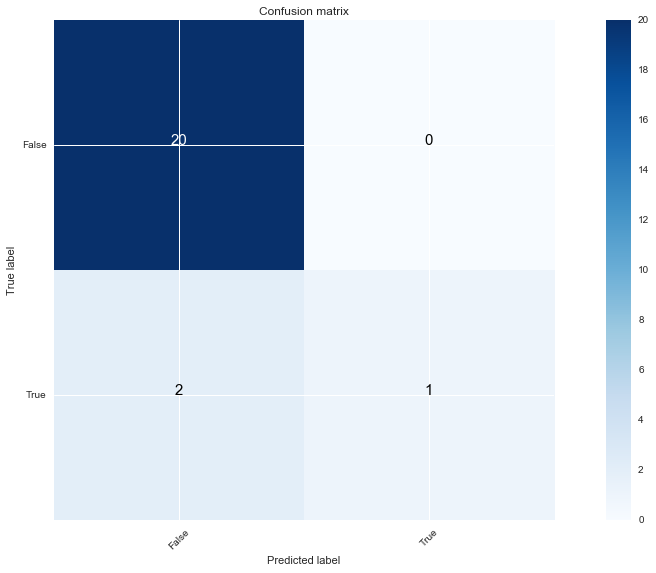

In [65]:
import matplotlib
matplotlib.rcParams.update({'font.size': 15})
matplotlib.rcParams['figure.figsize'] = (15.0, 8.0)

from plot_evaluation import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features_tf, labels, test_size=0.3, random_state=random_state)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, ["False","True"])

Looking at the confusion matrix above, I can immediately conclude that my classifier seems to have a very good precision in identifying POI's, since it has no false negatives. Hence, it is accusing a person of being a criminal only in case it is quite sure. However, it lacks some recall, since there are 2 cases where the classifier wrongly predicted a true POI not be a POI. It did not have enough evidence.<br> To further investigate the modell, I will look at the feature importance in the model. Specifically, I am interested, which words are helpful for identifying a POI.

In [66]:
sel = selector.get_support()
selected_indices = [int(i) for i, x in enumerate(sel) if x]
tfidf_word_list = vectorizer.get_feature_names()
keys = [tfidf_word_list[int(i)] for i in selected_indices]
keys.extend([u'total_payments',
       u'relative_receipt_from_poi', u'relative_shared_receipt_with_poi',
       u'relative_sent_to_poi'])

In [67]:
feat_imp = clf.feature_importances_
index_imp_dict = {}
for i,item in enumerate(feat_imp):
   index_imp_dict[keys[i]] = item
pd.DataFrame.from_dict([index_imp_dict]).transpose().sort_values(0, ascending=False).head(10)

,0
bucket,0.544023
relative_shared_receipt_with_poi,0.088430
oxley,0.016181
india20,0.015052
relative_sent_to_poi,0.010884
thoroughly,0.010884
dues20,0.009407
acceleration,0.009407
questionable,0.009102
exit,0.009070


The list above shows the most important features, which drive the performance of the classifier. It seems that especially the word "bucket" is a very good predictor for identifying a POI. I am curious what story hides behind that word.

In [68]:
# Get index of that word in the TF-IDF matrix
ind = vocab["bucket"]
tfidf=X.toarray().transpose()
doc_occurence = pd.DataFrame(tfidf[ind],index=full_data.index)
doc_occurence.sort_values(0, ascending=False).head(1)

,0
GLISAN JR BEN F,0.020547


In [69]:
data_dict["GLISAN JR BEN F"]

{'bonus': 600000,
 'deferral_payments': 'NaN',
 'deferred_income': 'NaN',
 'director_fees': 'NaN',
 'email_address': 'ben.glisan@enron.com',
 'exercised_stock_options': 384728,
 'expenses': 125978,
 'from_messages': 16,
 'from_poi_to_this_person': 52,
 'from_this_person_to_poi': 6,
 'loan_advances': 'NaN',
 'long_term_incentive': 71023,
 'other': 200308,
 'poi': True,
 'restricted_stock': 393818,
 'restricted_stock_deferred': 'NaN',
 'salary': 274975,
 'shared_receipt_with_poi': 874,
 'to_messages': 873,
 'total_payments': 1272284,
 'total_stock_value': 778546}

The investigation reveals that the word most often occured in the mails of GLISAN JR BEN F, who is a POI.

In [70]:
mail_address = data_dict["GLISAN JR BEN F"]['email_address']
mails_df = pd.read_pickle("email_content.pkl")
mails = mails_df[mails_df["email_address"]==mail_address]
clarifying_mails = []

for e in mails["mail_content"]:
    if  "bucket" in e:
        clarifying_mails.append(e)
print len(clarifying_mails)

from IPython.core.display import HTML
def foo():
    raw_html = clarifying_mails[3]
    return HTML(raw_html)
foo()

4


After some quick research it turns out that "bucket" refers to an email announcing a new Risk Management Policy in August 2001. The Enron scandal was publicized in October 2001. This is interesting, since it turned out that risk management practices at this company led to the bankruptcy of the Enron Corporation: <br><br>
*"Risk management was crucial to Enron not only because of its regulatory environment, but also because of its business plan. Enron established long-term fixed commitments which needed to be hedged to prepare for the invariable fluctuation of future energy prices. Enron's bankruptcy downfall was attributed to its reckless use of derivatives and special purpose entities. By hedging its risks with special purpose entities which it owned, Enron retained the risks associated with the transactions."* ([source](https://en.wikipedia.org/wiki/Enron_scandal#Timeline_of_downfall))

### Final model testing & performance

Using the external validation scheme provided by Udacity the final performance of my classifier is being determined. 

**Testing output:**

In [71]:
mydata = {}
for i,record in enumerate(features_tf):
    data = []
    for n,key in enumerate(keys):
        data.append((key,record[n]))
    data.append(("poi",full_data.iloc[i,1]))
    mydata[full_data.index[i]] = dict(data)

In [72]:
# Save locally
from tester import dump_classifier_and_data

# Insert "poi" into beginning of feature_list
keys.insert(0,"poi")

dump_classifier_and_data(clf, mydata, keys)

In [73]:
%%time
from tester import main
main()

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=120, presort='auto', random_state=42,
              subsample=1.0, verbose=0, warm_start=False)
	Accuracy: 0.94637	Precision: 0.87320	Recall: 0.66800	F1: 0.75694	F2: 0.70094
	Total predictions: 8000	True positives:  668	False positives:   97	False negatives:  332	True negatives: 6903

Wall time: 24min 45s


The test results show an approximate accuracy (F1 score) for identifying a True label of **76%** with an especially high precision score of **87%** and a recall score of 67%!